In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle

sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [2]:
acc0 = 89.45
beta_mean = 0.8260649245755485
mal_client_id = [3,6]

In [3]:
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10

for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'f_mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id :
                benign_params = list(client.parameters())[:2]
                att_type = 'unit' if idx == 3 else 'sign'
                if epoch % 2 == 0 :
                    mode = 'fisher'
                    fisher_matrix = {}
                    for param_name, param in client.named_parameters():
                        if param_name == 'conv1.0.weight':
                            grad = param.grad.cpu().detach().numpy()
                            if param_name not in fisher_matrix:
                                fisher_matrix[param_name] = grad ** 2
                            else:
                                fisher_matrix[param_name] += grad ** 2
                        if param_name == 'conv1.0.bias':
                            grad = param.grad.cpu().detach().numpy()
                            if param_name not in fisher_matrix:
                                fisher_matrix[param_name] = grad ** 2
                            else:
                                fisher_matrix[param_name] += grad ** 2
                    weight_positions = []
                    bias_positions = []
                    weight_positions.append(find_positions(fisher_matrix['conv1.0.weight'], 0.15))
                    bias_positions.append(find_positions(fisher_matrix['conv1.0.bias'], 0.15))
                else:
                    mode = 'Taylor'
                    Taylor_scores = {}
                    for param_name, param in client.named_parameters():
                        if param.grad is not None:
                            Taylor_scores[param_name] = torch.abs(param * param.grad)

                    weight_positions = []
                    bias_positions = []
                    weight_positions.append(find_positions(Taylor_scores['conv1.0.weight'].cpu().detach().numpy(), 0.15))
                    bias_positions.append(find_positions(Taylor_scores['conv1.0.bias'].cpu().detach().numpy(), 0.15))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

In [4]:
print(acc1_varying)
print(drop_varying)
print('-----------------------------')
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('-----------------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

[72.25999999999999, 73.30999999999999, 74.84666666666666, 76.725, 78.178, 78.98166666666665, 79.48714285714284, 78.75375, 79.2388888888889, 79.619]
[17.190000000000005, 16.140000000000008, 14.603333333333337, 12.725000000000003, 11.272000000000002, 10.468333333333337, 9.962857142857144, 10.696250000000003, 10.211111111111114, 9.831000000000001]
-----------------------------
acc1:
77.4515
1.453000000000003
-----------------------------
drop:
11.998500000000003
1.4530000000000012


In [ ]:
val = {
    'Baseline': [89.45],
    'Basic': [83.75, 83.59, 83.23],
    'Fisher+Taylor': [80.73, 77.45, 83.46],
}

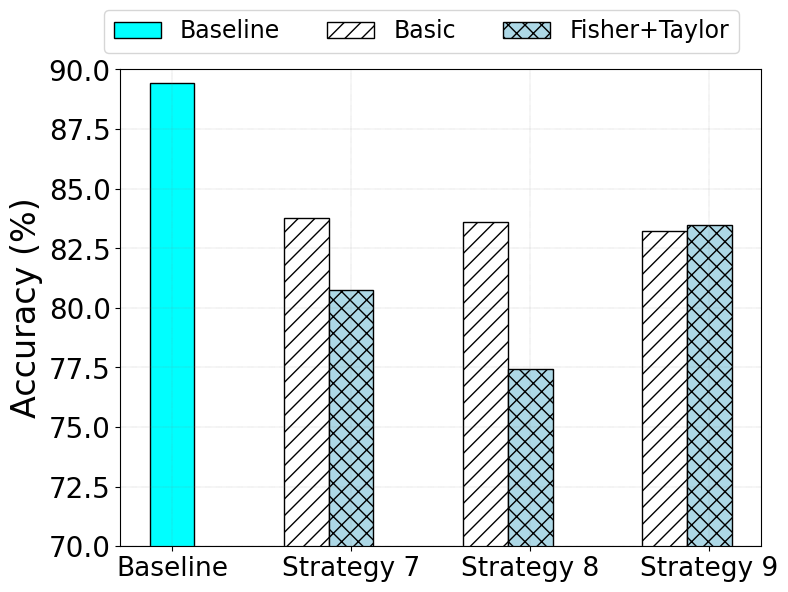

In [6]:
x = ['Baseline', 'Strategy 7', 'Strategy 8', 'Strategy 9']
val = {
    'Baseline': [89.45],
    'Basic': [83.75, 83.59, 83.23],
    'Fisher+Taylor': [80.73, 77.45, 83.46],
}

# 设置柱状图的宽度和 x 轴位置
bar_width = 0.25
x_positions = np.arange(len(x))

# 创建图表
fig, ax = plt.subplots(figsize=(8, 6))

# Baseline的单个柱状图
ax.bar(x_positions[0], val['Baseline'][0], width=bar_width, label='Baseline', color='cyan', edgecolor='black')

# 攻击策略的柱状图颜色和样式设置
# strategies = ['Basic', 'Fisher', 'Taylor']
# colors = ['white', 'deepskyblue', 'gray']
# hatches = ['//', '..', '\\']

strategies = ['Basic', 'Fisher+Taylor']
colors = ['white', 'lightblue']
hatches = ['//', 'xx']

# 绘制每个攻击策略的柱状图
for i, strategy in enumerate(strategies):
    for j in range(3):  # 每个策略有三个值
        ax.bar(
            x_positions[j + 1] + (i - 1) * bar_width,
            val[strategy][j],
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            hatch=hatches[i],
            label=strategy if j == 0 else ""  # 避免重复显示图例
        )

# 设置图例和轴标签
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)
plt.ylim(70, 90)
ax.legend(fontsize=17, loc='upper center', bbox_to_anchor=(0.47, 1.15), ncol=4)
ax.set_ylabel('Accuracy (%)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(x)
# 显示图表
plt.grid(True, linestyle=':', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()